In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from torchvision.transforms import v2
from torchvision.io import read_video
import matplotlib.pyplot as plt
from IPython.display import Video
import math
from torchcodec.decoders import VideoDecoder

In [2]:
# example video
video_pth = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task1_actions/training_subset/train/P04_41_003015_003031.mp4"
decoder = VideoDecoder(video_pth)
frames = []

for frame in decoder:
    # frame is a torch tensor: [C, H, W], dtype=torch.uint8
    frames.append(frame)

video = torch.stack(frames)  
# convert to channel first 
# video = torch.einsum('thwc->tchw', video) # convert to (t, c, h, w)
print(video.shape)

torch.Size([5, 3, 256, 256])


In [3]:
# example video
video_pth = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task1_actions/training_subset/train/P04_33_000471_000487.mp4"
video, audio, video_meta = read_video(video_pth, pts_unit="sec")
# convert to channel first 
video = torch.einsum('thwc->tchw', video) # convert to (t, c, h, w)
print(video.shape)

torch.Size([16, 3, 256, 256])


/home/kevinteng/Desktop/dev/llm/personal_projects/healthcare/trauma_thompson/.venv/lib/python3.12/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


In [4]:
def create_image_collage(image_list, num_cols=None, figsize=(10, 10)):
    """
    Creates an image collage from a list of image paths using matplotlib.pyplot.

    Args:
        image_paths (list): A list of file paths to the images.
        num_cols (int, optional): The number of columns in the collage grid.
                                   If None, it tries to create a square-like grid.
        figsize (tuple, optional): The size of the figure (width, height) in inches.
                                   Defaults to (10, 10).
    """

    num_images = len(image_list)

    if num_cols is None:
        num_cols = math.ceil(math.sqrt(num_images))
    num_rows = math.ceil(num_images / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    # Flatten axes for easy iteration, handling cases with a single row/column
    if num_rows == 1 and num_cols == 1:
        axes_flat = [axes]
    elif num_rows == 1 or num_cols == 1:
        axes_flat = axes
    else:
        axes_flat = axes.flatten()

    for i, img in enumerate(image_list):
        if i >= len(axes_flat): # Handle more images than subplots
            break
        axes_flat[i].imshow(img)
        axes_flat[i].axis('off')  # Hide axis labels and ticks
    # Hide any unused subplots
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()

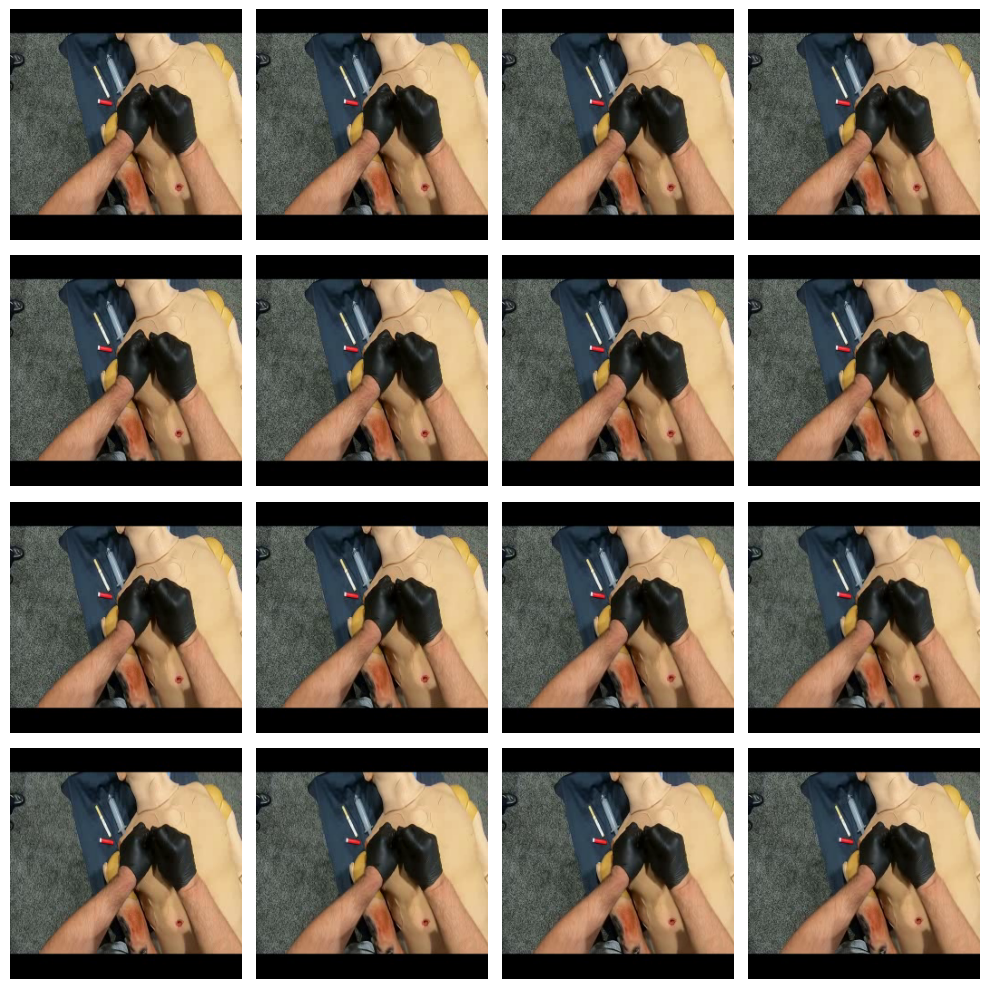

In [5]:
frame = [np.einsum('chw->hwc', frame) for frame in video.numpy()]
create_image_collage(frame, num_cols=4)

In [6]:
video_transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
        v2.RandomApply([v2.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
        )], p=0.5),
        v2.RandomApply([v2.RandomRotation(degrees=10)], p=0.5),
        v2.RandomApply([v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),
        v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        v2.RandomGrayscale(p=0.2),
        v2.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        v2.RandomApply([v2.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2))], p=0.5),
        v2.RandomAutocontrast(p=0.5),
        v2.RandomEqualize(p=0.5),
        v2.RandomErasing(p=0.5),
        v2.RandomInvert(p=0.5),
        v2.RandomPosterize(bits=4, p=0.5),
        v2.RandomSolarize(threshold=128, p=0.5),
        v2.ToDtype(torch.float32, scale=True),
    ]
)
augmented_video = video_transform(video)

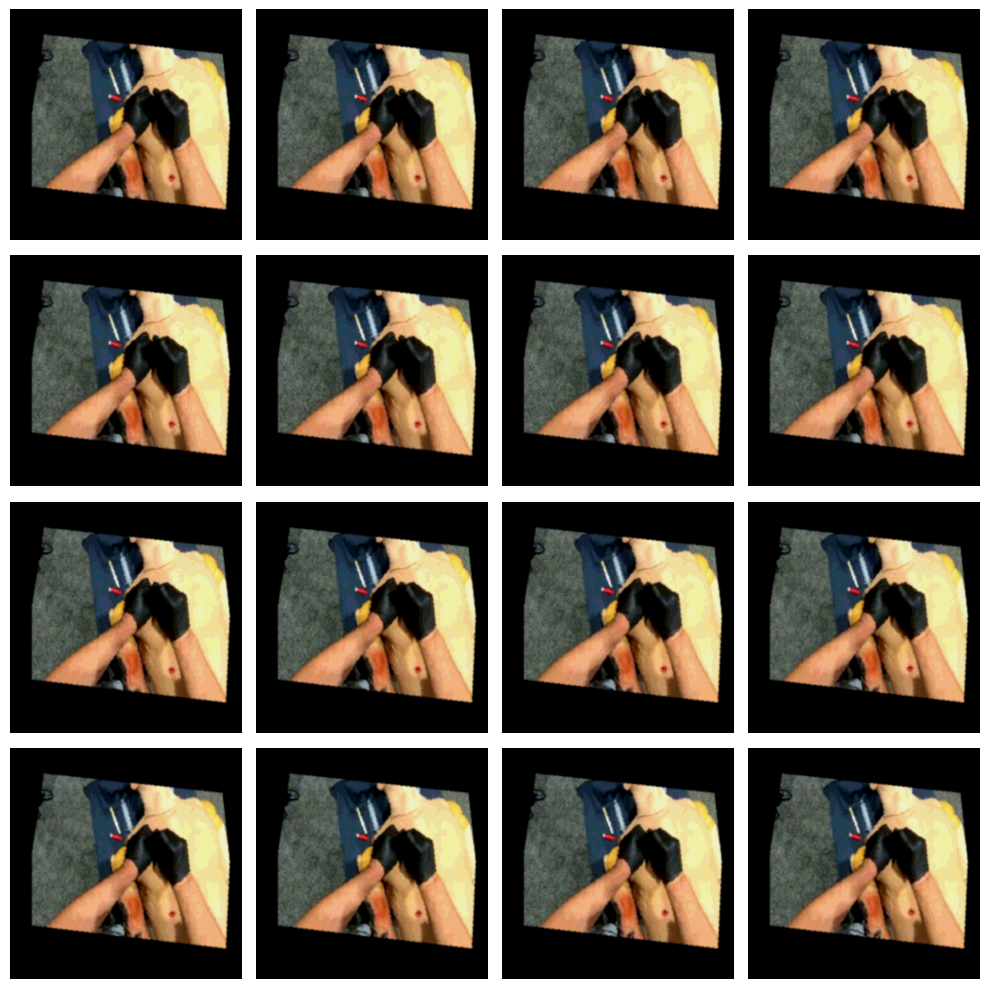

In [7]:
augmented_frame = [np.einsum('chw->hwc', frame) for frame in augmented_video.numpy()]
create_image_collage(augmented_frame, num_cols=4)

---

# Build Dataloader

In [8]:
class VideoDataset(Dataset):
    def __init__(self, csv_pth, video_dir, transform=None, mode="train"):
        self.csv_pth = csv_pth
        self.video_dir = video_dir
        self.transform = transform
        self.mode = mode
        # get train/val inputs
        self.df = pd.read_csv(csv_pth).query(f"split == '{mode}'")
        self.split_video_dir = os.path.join(video_dir, mode)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        video_pth = os.path.join(self.split_video_dir, self.df.iloc[idx]["clip_id"]+".mp4")
        video, audio, video_meta = read_video(video_pth, pts_unit="sec")
        video = torch.einsum('thwc->tchw', video) # convert to (t, c, h, w)
        if self.transform is not None:
            video = self.transform(video)
        return video, self.df.iloc[idx]["action_idx"]

In [9]:
csv_pth = "./outputs/data_prep_split.csv"
video_dir = "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task1_actions/training_subset/"

video_dataset = VideoDataset(csv_pth, video_dir, transform=video_transform, mode="train")
video_loader = DataLoader(video_dataset, batch_size=1, shuffle=True)

for batch, label in video_loader:
    print(batch.shape)
    print(label)
    break


torch.Size([1, 16, 3, 256, 256])
tensor([101])


/home/kevinteng/Desktop/dev/llm/personal_projects/healthcare/trauma_thompson/.venv/lib/python3.12/site-packages/torchvision/io/_video_deprecation_warning.py:5: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(
